## Notebook 5: Data loaders

In [143]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.torchdataset import DatasetFromDF, load_and_process_image

print(f'Project module version: {dm.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.post1.dev18+gbb11e12.d20231222


In [5]:
# Path settings 
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_disease')
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays', 'crop')
data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(dentex_dir, data_file_name)

### Create PyTorch dataset from data frame ###

In [114]:
data_df = pd.read_parquet(data_file)
# Convert class names to labels
cl_names = sorted(list(data_df['label'].unique()))
# Let's assign number to the classes
label_dict = dict(zip(cl_names, range(len(cl_names))))
cl_dict = dict(zip(label_dict.values(), label_dict.keys()))

# Add the class labels to the data frame
seed = np.random.seed(123)
data_df = data_df.\
                assign(cl=data_df['label'].apply(lambda l: label_dict.get(l))).\
                sample(frac=1, random_state=seed).\
                reset_index(drop=True)
display(data_df.head())

,height,width,id,file_name,image_number,file_path,quadrant,position,label,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset,cl
0,1504,2872,190,train_462.png,462,/app/data/dentex/dentex_disease/quadrant-enume...,3,6,Deep Caries,52032,"[1773.0, 837.0, 276.0, 320.0]",train_462_3_6,16,/app/data/dentex/dentex_disease/quadrant-enume...,276,320,train,1
1,1504,2872,40,train_383.png,383,/app/data/dentex/dentex_disease/quadrant-enume...,1,8,Caries,49882,"[816.0, 582.0, 229.0, 330.0]",train_383_1_8,9,/app/data/dentex/dentex_disease/quadrant-enume...,229,330,train,0
2,1316,2846,83,train_110.png,110,/app/data/dentex/dentex_disease/quadrant-enume...,1,7,Caries,29999,"[854.0, 371.0, 182.0, 268.0]",train_110_1_7,6,/app/data/dentex/dentex_disease/quadrant-enume...,182,268,train,0
3,1316,2945,321,train_620.png,620,/app/data/dentex/dentex_disease/quadrant-enume...,4,8,Impacted,48086,"[568.0, 738.0, 309.0, 219.0]",train_620_4_8,5,/app/data/dentex/dentex_disease/quadrant-enume...,309,219,val,2
4,1316,2753,689,train_138.png,138,/app/data/dentex/dentex_disease/quadrant-enume...,1,7,Caries,34908,"[698.5294117647059, 117.8235294117647, 141.176...",train_138_1_7,6,/app/data/dentex/dentex_disease/quadrant-enume...,141,384,train,0


In [109]:
# Class label definitions
display(label_dict)
# Maximum image size
max_im_width = data_df['im_width'].max()
max_im_height = data_df['im_height'].max()
print(f'Maximum image height across the data set: {max_im_height}')
print(f'Maximum image width across the data set:  {max_im_width}')

# The maximum dimension is the max_im_height:
max_im_size = np.max([max_im_height, max_im_width])

{'Caries': 0, 'Deep Caries': 1, 'Impacted': 2, 'Periapical Lesion': 3}

Maximum image height across the data set: 539
Maximum image width across the data set:  363


### PyTorch dataset from data frame ###
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [110]:
# Image augmentations as a component of the data set

# The output of this transformation must match the required input size for the model
im_size = 512

# Definition of the image augmentations for the training set
train_transform = alb.Compose([
    alb.Resize(im_size + 32, im_size + 32),
    alb.RandomCrop(im_size, im_size),
    alb.HorizontalFlip(),
    alb.ShiftScaleRotate(),
    alb.Blur(),
    alb.RandomGamma(),
    alb.Sharpen(),
    alb.GaussNoise(),
    alb.CoarseDropout(16, 32, 32),
    alb.CLAHE(),
    alb.Normalize(mean=0, std=1)])

# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
val_tranform = alb.Compose([
    alb.Resize(im_size, im_size),
    alb.Normalize(mean=0, std=1)])

In [111]:
# Select the training samples from our data frame
train_df = data_df.loc[data_df['dataset']=='train']
display(train_df['label'].value_counts())

# Create a PyTorch dataset
train_set = DatasetFromDF(data=train_df,
                          file_col='box_file',
                          label_col='cl',
                          max_image_size=max_im_size,
                          transform=train_transform,
                          validate=True)

label
Caries               1597
Deep Caries           433
Impacted              416
Periapical Lesion     130
Name: count, dtype: int64

### Retrieve one image from the data set ###
Everytime the cell is run, a difference augmentation is generated from the same image

In [184]:
def image_stats(ig, decimals=3):
    
    output_dict = {'width': ig.shape[1],
                   'height': ig.shape[0],
                   'mean': np.round(np.mean(ig), decimals=decimals),
                   'std': np.round(np.std(ig), decimals=decimals),
                   'min': np.round(np.min(ig), decimals=decimals),
                   'max': np.round(np.max(ig), decimals=decimals)}
    
    return pd.DataFrame(output_dict, index=[0])

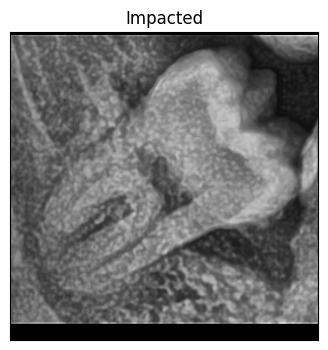

,width,height,mean,std,min,max
0,512,512,0.396,0.179,0.0,1.0


In [188]:
# Retrieve one (image, label) sample from the data set
image_index = 695
image_sample, label_sample = train_set[image_index]
image = np.squeeze(image_sample.numpy())
label = cl_dict.get(int(label_sample.numpy()))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set(xticks=[], yticks=[], title=str(label))
plt.show()
print()
display(image_stats(image))